<a href="https://colab.research.google.com/github/xmpuspus/nyc-real-estate-pricing/blob/master/TabularRegressionFastAI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [0]:
import gc
gc.collect()

0

In [0]:
# Load FastAI
from fastai import *
from fastai.tabular import *

In [0]:
# train test split
from sklearn.model_selection import train_test_split

In [0]:
# Load data from google drive
from google.colab import drive

drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
data_repo_url = '/content/gdrive/My Drive/Datasets/'
data_url = data_repo_url + 'NYC House Prices/nyc-rolling-sales.csv'

In [0]:
# Load Data
data = pd.read_csv(data_url)

### Clean Data
# Convert to float
data['SALE PRICE'] = pd.to_numeric(data['SALE PRICE'], errors='coerce')
data['SALE PRICE'] = data['SALE PRICE'].fillna(0)

data['GROSS SQUARE FEET'] = pd.to_numeric(data['GROSS SQUARE FEET'], errors='coerce')
data['LAND SQUARE FEET'] = pd.to_numeric(data['LAND SQUARE FEET'], errors='coerce')

# Convert to date
data['SALE DATE'] = pd.to_datetime(data['SALE DATE'], errors='coerce')


# Remove 5th and 95th percentile tails
zero = 0
fifth = data['SALE PRICE'].describe(np.arange(0.05, 1, 0.05)).T['15%']
ninetyfifth = data['SALE PRICE'].describe(np.arange(0.05, 1, 0.05)).T['95%']
data = data[(data['SALE PRICE'] > zero) &
             (data['SALE PRICE'] <= ninetyfifth)].copy()

data.dropna(inplace=True)

In [0]:
# data.dropna(subset=['SALE PRICE'], inplace=True)

In [0]:
data.shape

(36128, 22)

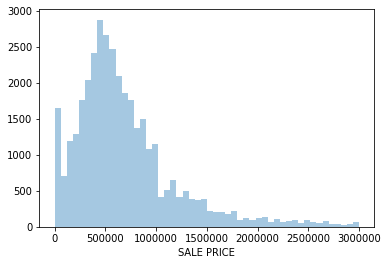

In [0]:
sns.distplot(data['SALE PRICE'], kde=False)

In [0]:
dep_var = 'SALE PRICE'
cat_names = ['BOROUGH', 'NEIGHBORHOOD', 'BUILDING CLASS CATEGORY', 'TAX CLASS AT PRESENT',
              'BUILDING CLASS AT PRESENT', 'BUILDING CLASS AT TIME OF SALE']
cont_names = ['LAND SQUARE FEET', 'GROSS SQUARE FEET', 'RESIDENTIAL UNITS', 
              'COMMERCIAL UNITS']

In [0]:
print("Categorical columns are : ", cat_names)
print('Continuous numerical columns are :', cont_names)
procs = [FillMissing, Categorify, Normalize]

Categorical columns are :  ['BOROUGH', 'NEIGHBORHOOD', 'BUILDING CLASS CATEGORY', 'TAX CLASS AT PRESENT', 'BUILDING CLASS AT PRESENT', 'BUILDING CLASS AT TIME OF SALE']
Continuous numerical columns are : ['LAND SQUARE FEET', 'GROSS SQUARE FEET', 'RESIDENTIAL UNITS', 'COMMERCIAL UNITS']


In [0]:
df_train, df_test = train_test_split(data, test_size=0.33, random_state=42)

In [0]:
df_train.shape, df_test.shape

((24205, 22), (11923, 22))

In [0]:
# Transformations
procs = [FillMissing, Categorify, Normalize]

# Test tabularlist
test = TabularList.from_df(df_test, cat_names=cat_names, cont_names=cont_names, procs=procs)

# Train data bunch
data = (TabularList.from_df(df_train, path='.', cat_names=cat_names, cont_names=cont_names, procs=procs)
                        .split_by_rand_pct(valid_pct = 0.1, seed = 42)
                      .label_from_df(cols = dep_var, label_cls = FloatList, log=True)
                        .add_test(test)
                        .databunch())
data.show_batch(rows=10)

BOROUGH,NEIGHBORHOOD,BUILDING CLASS CATEGORY,TAX CLASS AT PRESENT,BUILDING CLASS AT PRESENT,BUILDING CLASS AT TIME OF SALE,LAND SQUARE FEET,GROSS SQUARE FEET,RESIDENTIAL UNITS,COMMERCIAL UNITS,target
4,SPRINGFIELD GARDENS,02 TWO FAMILY DWELLINGS,1,B1,B1,0.1062,-0.0498,0.0166,-0.1508,13.151922
3,FLATBUSH-EAST,02 TWO FAMILY DWELLINGS,1,B2,B2,0.0265,0.0252,0.0166,-0.1508,13.71015
4,HOLLIS,01 ONE FAMILY DWELLINGS,1,A1,A1,0.0265,-0.0126,-0.0532,-0.1508,2.3025851
3,FLATBUSH-LEFFERTS GARDEN,10 COOPS - ELEVATOR APARTMENTS,2,D4,D4,-0.0864,-0.0846,-0.1230,-0.1508,13.10216
4,FOREST HILLS,01 ONE FAMILY DWELLINGS,1,A1,A1,-0.0085,-0.0206,-0.0532,-0.1508,14.237505
4,JAMAICA,02 TWO FAMILY DWELLINGS,1,S2,S2,0.3194,0.0335,0.0166,1.6466,11.526484
3,BRIGHTON BEACH,05 TAX CLASS 1 VACANT LAND,1B,V0,V0,-0.0356,-0.0846,-0.1230,-0.1508,11.921719
2,BAYCHESTER,02 TWO FAMILY DWELLINGS,1,B2,B2,-0.0194,-0.0099,0.0166,-0.1508,13.3129835
3,FLATBUSH-EAST,03 THREE FAMILY DWELLINGS,1,C0,C0,-0.0285,-0.0079,0.0864,-0.1508,13.3878
2,WILLIAMSBRIDGE,02 TWO FAMILY DWELLINGS,1,B1,B1,-0.0058,0.0021,0.0166,-0.1508,12.8992195


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


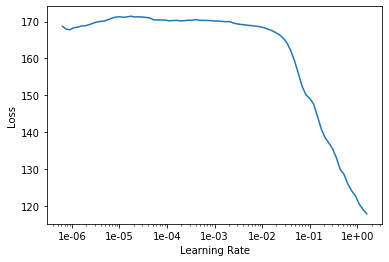

In [0]:
# Create deep learning model
learn = tabular_learner(data, layers=[100, 100], metrics=rmse)

# select the appropriate learning rate
learn.lr_find()

# we typically find the point where the slope is steepest
learn.recorder.plot()

In [0]:
# Fit the model based on selected learning rate
learn.fit_one_cycle(20, max_lr =1e-03,)

epoch,train_loss,valid_loss,root_mean_squared_error,time
0,166.824600,167.339813,12.935114,00:06
1,145.795837,143.021210,11.955709,00:06
2,58.173405,46.967213,6.851585,00:05
3,4.405716,3.654267,1.848587,00:05
4,3.591591,3.570382,1.772290,00:05
5,3.491438,4.974111,2.068980,00:05
6,3.060440,4.120715,1.772323,00:05
7,3.110218,3.213185,1.670919,00:05
8,3.157091,3.320865,1.722400,00:05
9,3.547643,3.232132,1.713026,00:06


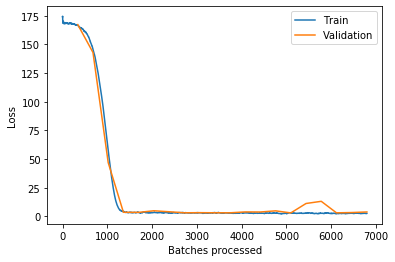

In [0]:
# Analyse our model
learn.model
learn.recorder.plot_losses()


In [0]:
# get predictions
preds, targets = learn.get_preds(DatasetType.Test)
labels = [np.exp(p[0].data.item()) for p in preds]


In [0]:
preds_df = pd.Series([i[0].data.item() for i in preds])
preds_df.head()

0    11.710226
1    12.389363
2    12.810046
3    13.066483
4    13.111695
dtype: float64

In [0]:
labels_df = pd.Series(labels)
labels_df.shape

(11923,)

In [0]:
df_test['SALE PRICE'].shape

(11923,)

In [0]:
# model metrics package
from sklearn.metrics import mean_squared_error as mse

In [0]:
# RMSE
np.sqrt(mse(np.log(df_test['SALE PRICE']), preds_df))

92.72203991081267

In [0]:
predictions_df = pd.DataFrame({'y_true': np.log(df_test.reset_index()['SALE PRICE']), 
                               'y_pred': preds_df})

# Filter for erroneous predictions
predictions_df = predictions_df[predictions_df['y_pred'] > 0]

# Filter for predictions only below max of true value
predictions_df = predictions_df[predictions_df['y_pred'] < predictions_df['y_true'].max()]

# Filter for a better looking box
predictions_df = predictions_df[predictions_df['y_true'] > 8]
predictions_df = predictions_df[predictions_df['y_pred'] > 8]
predictions_df.head()

,y_true,y_pred
1,11.407565,12.389363
3,13.415033,13.066483
4,13.091904,13.111695
5,8.978156,13.399941
6,13.102161,12.583257


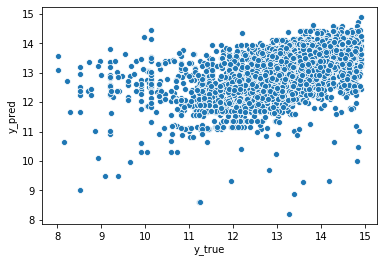

In [0]:
sns.scatterplot(data=predictions_df,
                 x='y_true',
                 y='y_pred')